# Active Learning for AMR

This project includes data, scripts, and Jupyter notebooks for analysis of performance of Active Learning techniques applied to Adaptive Mesh Refinement (AMR) simulations. Specifially, we consider AMR simulations of a shock-bubble interaction phenomenon (visualization is shown below). We train and evaluate Active Learning algorithms on the data from AMR simulation runs performed on Edison supercomputer at NERSC (US National Energy Research Computing Center). 

#### Contributors:
- Dmitry Duplyakin <dmitry.duplyakin@utah.edu>
- Jed Brown <jed@jedbrown.org>
- Donna Calhoun <donnacalhoun@boisestate.edu>

#### References:
- Active Learning: 
    * Previous work: http://ieeexplore.ieee.org/document/7776508/
    * Active-learning-based surrogate modeling: http://ieeexplore.ieee.org/document/6702683/
    * Survey: http://burrsettles.com/pub/settles.activelearning.pdf
- AMR with ForestClaw: https://arxiv.org/abs/1308.1472
- Edison: http://www.nersc.gov/users/computational-systems/edison/

<img src="shockbubble_example.png" style="height:180px">

### This notebook helps produce plots for Active Learning algorithm trade-off analysis (including plots for the paper) 

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
# Improve plot quality for retina displays
%config InlineBackend.figure_format = 'retina'

# Choose seaborn style
sns.set_style("whitegrid")

# Allows setting values in dataframe copies without warnings (default='warn')
pd.options.mode.chained_assignment = None 

# Define helper functions
def get_color_map(unique_values, palette="bright"):
    """ For a given list of elements, return a dict where keys are those elements and values are unique colors 
    from the specified palette """
    rgb_values = sns.color_palette(palette, len(unique_values))
    return dict(zip(unique_values, rgb_values))

def get_alg_cmap():
    """ For consistency, always use the same colors for candidate selection algorithms """
    return {"RGMA": "crimson",
            "RandUniform": "darkorange",
            "RandGoodness": "dodgerblue",
            "MaxSigma": "darkmagenta",
            "MinPred": "olivedrab"}

def get_algs():
    """ For consistency, always iterate over algorithms in a certain order """
    return ["RandUniform", "MaxSigma", "MinPred", "RandGoodness", "RGMA"]

def get_n_cmap():
    """ For consistency, always use the same colors for n_init_rel values"""
    return {0.0025: "lightcoral",
            0.1250: "crimson",
            0.2500: "darkred"}

def get_n_line():
    """ For consistency, always use the same line style for n_init_rel values"""
    return {0.0025: "--",
            0.1250: "-",
            0.2500: "-."}

def save_and_show(fig, file_name, dest_dir="./"):
    """ Save given figure object as pdf with the given name inside the given directory"""
    dest_file = os.path.join(dest_dir, file_name)
    fig.savefig(dest_file, bbox_inches='tight')
    print "Saved plot as: %s" % dest_file
    
def n_init_rel_to_abs(n_init_rel, total=400):
    """ For show absolute n_init values on plots, convert relative numbers to abolute numbers. 
    400 samples is what is left from the set after setting aside 200 test samples in our evaluation"""
    return int(total * n_init_rel)
  
# Choose figure size appropriate for the paper
fs=(4, 4)

In [2]:
# Load datasets from csv files and combine them into a single dataframe
data_dir = "./trajectories/"

# Combine all datasets from csv files in data_dir into a single dataframe
data_all = []
for f in os.listdir(data_dir):
    if f.endswith(".csv"):
        data_all.append(pd.read_csv(data_dir + f, index_col=0))
data_all = pd.concat(data_all)       
        
print "Total rows in combined dataframe: ", len(data_all) 
data_all.sample(20)

Total rows in combined dataframe:  164217


,Iteration,Number of Processors,Grid Size,Maximum Refinement Level,Bubble Size,Bubble Density,"log(Cost, Node-Hours)",Pred. Mean,Pred. Sigma,Max Sigma,...,Hyperparameter-2,LML Max,Pred. Sigma Avg.,Cumulative Cost,Cumulative Regret,MaxRSS,rep,Candidate Selection,mem_limit_rel,n_init_rel
161,162.0,16.0,8.0,4.0,0.3,0.100,-1.706838,-1.676517,0.119022,0.136635,...,-4.323316,67.986760,0.120279,179.873033,109.836277,6.429925,12,RandUniform,0.95,0.0025
136,137.0,4.0,32.0,5.0,0.4,0.100,-0.198598,-0.304884,0.125485,0.125485,...,-4.310686,26.834359,0.123855,275.337044,204.277752,7.117374,15,MaxSigma,0.95,0.0025
121,122.0,4.0,32.0,5.0,0.3,0.050,-0.260298,-0.260494,0.135088,0.135088,...,-4.108456,67.913744,0.134030,288.373526,124.672924,7.131005,3,MaxSigma,0.95,0.2500
54,55.0,4.0,8.0,6.0,0.2,0.025,-0.801367,-1.205680,0.119813,0.119813,...,-4.337064,23.695855,0.123907,177.147353,109.278778,7.067205,9,MaxSigma,0.95,0.1250
119,120.0,16.0,8.0,6.0,0.5,0.200,-0.953385,-0.947166,0.121759,0.330816,...,-4.495989,70.901310,0.119221,80.990318,1.248033,6.448684,13,RandGoodness,0.95,0.1250
126,127.0,4.0,32.0,4.0,0.5,0.200,-0.836739,-0.757692,0.132357,0.132357,...,-4.165540,50.085196,0.131308,285.009191,176.080923,7.037405,1,MaxSigma,0.95,0.1250
261,262.0,8.0,32.0,5.0,0.5,0.100,NaN,-0.072876,0.105662,0.117982,...,-4.583909,157.262790,0.106087,320.690429,160.772824,7.156602,0,RandUniform,0.95,0.1250
172,173.0,8.0,32.0,4.0,0.5,0.400,-0.565452,-0.583994,0.111078,0.156894,...,-4.537428,116.128665,0.112831,71.510931,0.000000,6.633135,9,MinPred,0.95,0.1250
265,266.0,8.0,32.0,4.0,0.3,0.050,-0.567052,-0.585430,0.092644,0.144472,...,-4.804133,157.908597,0.096907,271.132220,126.369719,7.029666,9,RGMA,0.95,0.0025
347,348.0,16.0,32.0,5.0,0.3,0.200,0.046980,0.086291,0.091898,0.091898,...,-4.806336,229.236245,0.095311,394.113900,199.621977,7.033635,26,MaxSigma,0.95,0.1250


Saved plot as: ./CR-by-alg.pdf


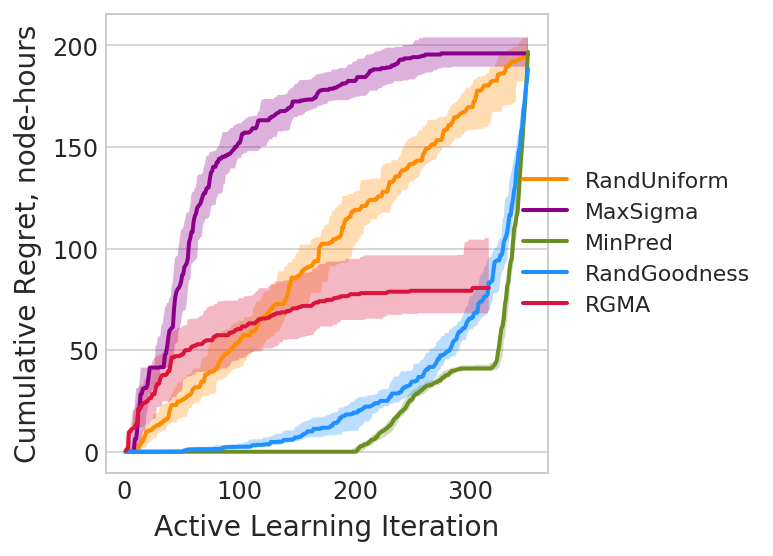

In [3]:
# Plot selected metric for a fixed init ratio: n_init_rel=0.1250

metric = "Cumulative Regret"
selected_data = data_all[data_all["n_init_rel"] == 0.1250]

cmap = get_alg_cmap()
    
fig, ax = plt.subplots(figsize=fs)

for alg in get_algs():
    
    grp = selected_data[selected_data['Candidate Selection'] == alg]

    # Show median
    grp_iter = grp.groupby(['Iteration'])
    med = grp_iter.median() 
    ax.plot(med.index, med["Cumulative Regret"], lw = 2.0, c=cmap[alg], alpha = 1.0, label=alg)

    # Show IQRs
    ax.fill_between(med.index, 
                    grp_iter["Cumulative Regret"].quantile([.25]), 
                    grp_iter["Cumulative Regret"].quantile([.75]), 
                    facecolor=cmap[alg], alpha=0.3) 

    ax.xaxis.grid(False)

# Additional figure styling
ax.set_ylabel("Cumulative Regret, node-hours", fontsize=14, labelpad=5)
ax.set_xlabel("Active Learning Iteration", fontsize=14, labelpad=5)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)    
    
# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 0.8, box.height]);

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.7),
          fancybox=False, shadow=False, frameon=False, 
          ncol=1, fontsize=11);
    
fig.tight_layout()
save_and_show(fig, "CR-by-alg.pdf")

Saved plot as: ./CR-by-nInit.pdf


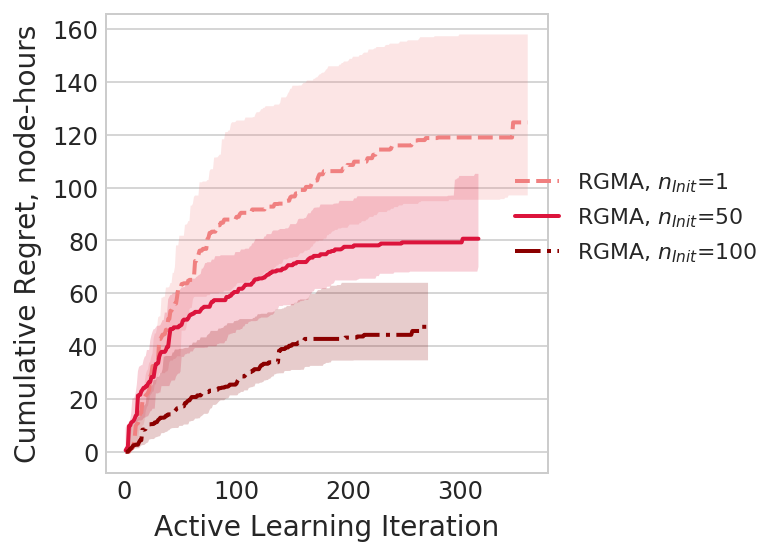

In [4]:
# Visualize variations of RGMA with different n_init_rel values 

rgma = data_all[data_all["Candidate Selection"] == "RGMA"]
  
cmap = get_n_cmap()
    
metric = "Cumulative Regret"

fig, ax = plt.subplots(figsize=fs)
ax.set_ylabel("Cumulative Regret, node-hours", fontsize=14, labelpad=5)
ax.set_xlabel("Active Learning Iteration", fontsize=14, labelpad=5)

for n_init_rel, grp in rgma.groupby("n_init_rel"):

    iter_max = grp['Iteration'].max() 
    
    # Show median
    grp_iter = grp.groupby(['Iteration'])
    med = grp_iter.median() 
    ax.plot(med.index, med[metric], get_n_line()[n_init_rel], lw = 2.0, c=cmap[n_init_rel], alpha = 1.0, 
            label = "RGMA, $n_{Init}$=%d" % n_init_rel_to_abs(n_init_rel))

    # Show IQRs
    ax.fill_between(med.index, grp_iter[metric].quantile([.25]), grp_iter[metric].quantile([.75]), 
                    facecolor=cmap[n_init_rel], alpha=0.2) 

# Additional figure styling
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.xaxis.grid(False)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 0.8, box.height]);

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.7),
          fancybox=False, shadow=False, frameon=False, 
          ncol=1, fontsize=11);

fig.tight_layout()
save_and_show(fig, "CR-by-nInit.pdf")

Saved plot as: ./rmse.pdf


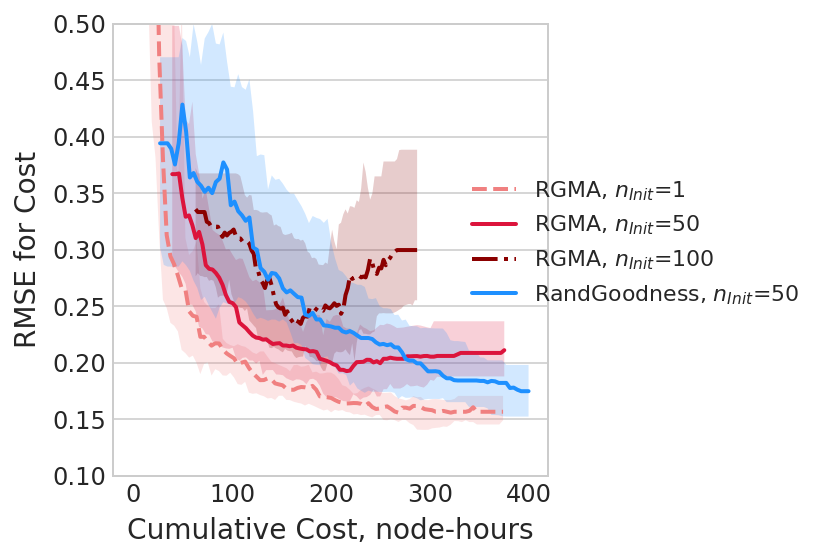

In [5]:
# Visualize RMSE as a function of cumulative cost for different algorithms

cc_val_count = 100

fig, ax = plt.subplots(figsize=fs)

for key, grp in rgma.groupby(['Candidate Selection', 'n_init_rel']):
    alg, n_init_rel = key
    alg_smooth = np.empty((cc_val_count, len(grp["rep"].unique())))
    
    cc_vals = np.linspace(grp['Cumulative Cost'].min(), grp['Cumulative Cost'].max(), cc_val_count)
    
    for idx, (r, subgrp) in enumerate(grp.groupby(['rep'])):
        x_cc = subgrp['Cumulative Cost'].as_matrix()
        y_rmse = subgrp['Cost Pred. Error'].as_matrix()

        # x_cc should monotonically increase (it is cumulative cost); no need to sort it
        
        # Use linear interploation for connecting points (x_cc, y_rmse)
        rmse_vals = np.interp(cc_vals, x_cc, y_rmse)

        alg_smooth[:, idx] = rmse_vals
        
    alg_smooth_df = pd.DataFrame(alg_smooth)
    alg_rmse_median = alg_smooth_df.median(axis=1)
    
    curr_col = cmap[n_init_rel] if alg == "RGMA" else cmap[alg]
    
    ax.plot(cc_vals, alg_rmse_median, get_n_line()[n_init_rel], c=curr_col, 
            label = "RGMA, $n_{Init}$=%d" % n_init_rel_to_abs(n_init_rel), 
            lw = 2.0, alpha = 1.0)  

    # Show quantiles as filled areas
    lb = alg_smooth_df.quantile([.25], axis=1).as_matrix().flatten()
    ub = alg_smooth_df.quantile([.75], axis=1).as_matrix().flatten()
    ax.fill_between(cc_vals, lb, ub, facecolor=curr_col, alpha=0.2)

# Add RangGoodness to the plot
rg = data_all[(data_all["Candidate Selection"] == "RandGoodness") & (data_all["n_init_rel"] == 0.1250)]
for data_plot in [rg]:
    for key, grp in data_plot.groupby(['Candidate Selection', 'n_init_rel']):
        alg, n_init_rel = key
        alg_smooth = np.empty((cc_val_count, len(grp["rep"].unique())))

        cc_vals = np.linspace(grp['Cumulative Cost'].min(), grp['Cumulative Cost'].max(), cc_val_count)

        for idx, (r, subgrp) in enumerate(grp.groupby(['rep'])):
            x_cc = subgrp['Cumulative Cost'].as_matrix()
            y_rmse = subgrp['Cost Pred. Error'].as_matrix()
            rmse_vals = np.interp(cc_vals, x_cc, y_rmse)
            alg_smooth[:, idx] = rmse_vals
            
        alg_smooth_df = pd.DataFrame(alg_smooth)
        alg_rmse_median = alg_smooth_df.median(axis=1)

        curr_col = get_alg_cmap()[alg]

        ax.plot(cc_vals, alg_rmse_median, get_n_line()[n_init_rel], c=curr_col, 
                label = "%s, $n_{Init}$=%d" % (alg, n_init_rel_to_abs(n_init_rel)), 
                lw = 2.0, alpha = 1.0)  

        # Show quantiles as filled areas
        lb = alg_smooth_df.quantile([.25], axis=1).as_matrix().flatten()
        ub = alg_smooth_df.quantile([.75], axis=1).as_matrix().flatten()
        ax.fill_between(cc_vals, lb, ub, facecolor=curr_col, alpha=0.2)
    
# Additional styling
ax.set_xlabel('Cumulative Cost, node-hours', fontsize=14, labelpad=5)
ax.set_ylabel('RMSE for Cost', fontsize=14, labelpad=5)
ax.xaxis.grid(alpha=0.5)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)
ax.set_ylim([0.1, 0.5])
ax.xaxis.grid(False)

# Shrink current axis's height by 10% on the bottom
box = ax.get_position()
ax.set_position([box.x0, box.y0,
                 box.width * 0.8, box.height]);

# Put a legend below current axis
ax.legend(loc='upper center', bbox_to_anchor=(1.2, 0.7),
          fancybox=False, shadow=False, frameon=False, 
          ncol=1, fontsize=11);

fig.tight_layout()
save_and_show(fig, 'rmse.pdf')

Saved plot as: ./violins.pdf


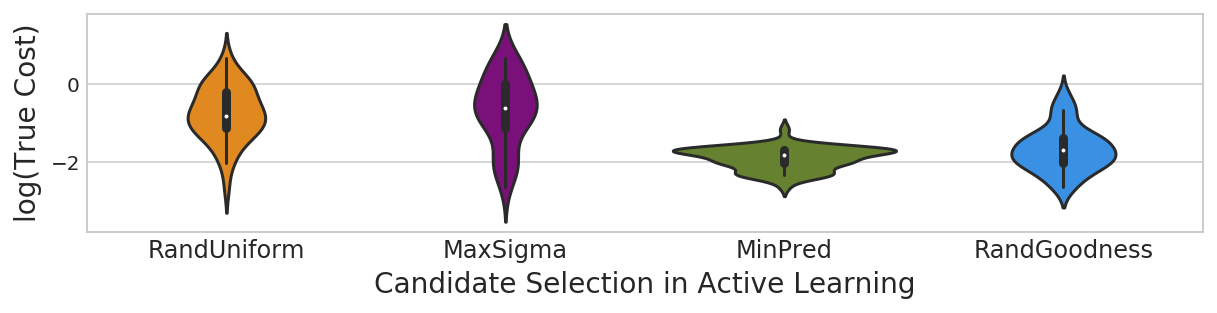

In [6]:
# Show violin plots for cost of the experiments selected up to the specified iteration 

iter_limit = 150

data_plot = data_all[(data_all["n_init_rel"] == 0.125) & (data_all["rep"] == 1) & (data_all["Iteration"] <= 50)]

fig, ax = plt.subplots(figsize=(10, 2)) 

violin_order = ["RandUniform", "MaxSigma", "MinPred", "RandGoodness"] 
violin_cmap = get_alg_cmap()
violin_colors = [violin_cmap[x] for x in violin_order]
sns.violinplot(x="Candidate Selection", y="log(Cost, Node-Hours)", \
               order=violin_order, \
               data=data_plot, palette=violin_colors, ax=ax)

# Additional styling
ax.set_ylabel("log(True Cost)", fontsize=14)
ax.set_xlabel("Candidate Selection in Active Learning", fontsize=14)
plt.setp(ax.get_xticklabels(), fontsize=12)

save_and_show(fig, 'violins.pdf')